In [6]:
import glob
import re
import pandas as pd

# 指定包含CSV文件的文件夹路径
csv_files = glob.glob(r"H:\3Ddom\segment_anything_backups\data_output\101ND750\images_3_samauto_1\DSC_*\metadata.csv")
print("csv_files: 999 files...")
print("start merging...")
merged_df = pd.DataFrame()

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dsc_folder_value =  re.search(r'\\(\w+)_output\\', csv_file).group(1)
    dsc_value = csv_file.split('\\')[-2]  # 获取 DSC_* 部分
    df['DSC_folder'] = dsc_folder_value
    df['DSC'] = dsc_value
    merged_df = pd.concat([merged_df, df], ignore_index=True)
print("metadata length: ",len(merged_df))
print("metadata columns: ", merged_df.columns.tolist())


csv_files: 999 files...
start merging...
metadata length:  37519
metadata columns:  ['id', 'area', 'bbox_x0', 'bbox_y0', 'bbox_w', 'bbox_h', 'point_input_x', 'point_input_y', 'predicted_iou', 'stability_score', 'crop_box_x0', 'crop_box_y0', 'crop_box_w', 'crop_box_h', 'DSC_folder', 'DSC']


In [ ]:
###################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

selected_column = ['area', 'bbox_x0', 'bbox_y0', 'bbox_w', 'bbox_h']

selected_data = merged_df[selected_column]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_data)

dbscan = DBSCAN(eps=0.3, min_samples=10)
labels = dbscan.fit_predict(scaled_data)

merged_df["labels"] = labels
mask = merged_df["labels"]==0

slices = merged_df[mask].groupby("DSC")["stability_score"].idxmax()
merged_df.loc[slices][["DSC_folder", "DSC", "id"]]

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

selected_column = ['area', 'bbox_x0', 'bbox_y0', 'bbox_w', 'bbox_h']

selected_data = merged_df[selected_column]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_data)

dbscan = DBSCAN(eps=0.3, min_samples=10)
labels = dbscan.fit_predict(scaled_data)

print("labels: ", pd.DataFrame(labels, columns=["labels"]).value_counts())

labels:  labels
 2        34097
 3         1035
 0         1001
 1          999
 4          154
-1          142
 5           55
 6           20
 7           16
dtype: int64


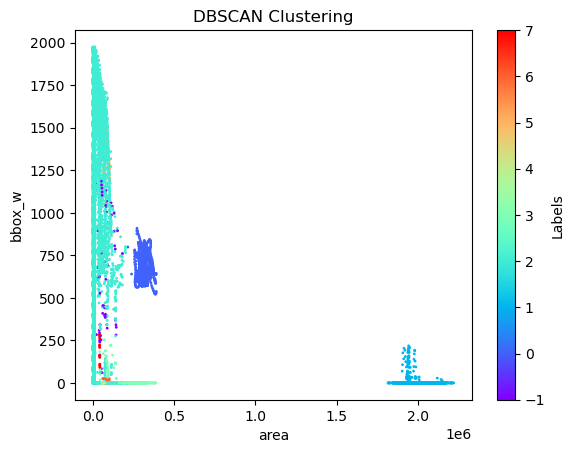

In [9]:
plt.scatter(selected_data['area'], selected_data['bbox_x0'], c=labels, cmap='rainbow', s=1)
plt.xlabel("area")
plt.ylabel("bbox_w")
plt.title('DBSCAN Clustering')

cbar = plt.colorbar()
cbar.set_label('Labels')

plt.show()

In [12]:
merged_df["labels"] = labels
mask = merged_df["labels"]==0


print("groupby'DSC': ..... ")
print(merged_df[mask]["DSC"].value_counts())


slices = merged_df[mask].groupby("DSC")["stability_score"].idxmax()
merged_df.loc[slices][["DSC_folder", "DSC", "id"]]

groupby'DSC': ..... 
DSC_3231    2
DSC_4019    2
DSC_3065    1
DSC_3865    1
DSC_3853    1
           ..
DSC_3403    1
DSC_3404    1
DSC_3405    1
DSC_3406    1
DSC_4192    1
Name: DSC, Length: 999, dtype: int64


,DSC_folder,DSC,id
0,data,DSC_3065,0
47,data,DSC_3066,1
71,data,DSC_3067,0
115,data,DSC_3068,0
147,data,DSC_3069,0
...,...,...,...
37451,data,DSC_4188,0
37472,data,DSC_4189,1
37484,data,DSC_4190,1
37498,data,DSC_4191,1


In [67]:
import os
import cv2

# 原始路径

# 遍历路径进行替换和迭代
for folder_name, dsc, id_name in merged_df.loc[slices][["DSC_folder", "DSC", "id"]].values[:1]:
    # mask_layer_path
    original_path = r'H:\3Ddom\segment_anything_backups\data_output\101ND750\images_3_samauto_1\DSC_3065\0.png'
    parts_path = original_path.split('\\')[:-2]
    parts_path.append(dsc)
    parts_path.append((str(id_name) + '.png'))
    layer_path = '\\'.join(map(lambda x: os.path.join('', x), parts_path))
    # img_path
    original_path = r"H:\3Ddom\segment_anything_backups\data\101ND750\images_3\DSC_3065.png"
    parts_path = original_path.split('\\')[:-1]
    parts_path.append((dsc + '.png'))
    img_path = '\\'.join(map(lambda x: os.path.join('', x), parts_path))
    # overlap
    layer = cv2.imread(layer_path)
    img = cv2.imread(img_path)
    alpha = 0.5
    result = cv2.addWeighted(img, 1 - alpha, layer, alpha, 0)
    result_path = f"./result_mask/{dsc}_mask.png"
    cv2.imwrite(result_path, result)
    # extract
    extracted_part = np.zeros_like(img)
    extracted_part[layer == 255] = img[layer == 255]
    extracted_part_path = f"./result_mask/{dsc}_extract.png"
    cv2.imwrite(extracted_part_path, extracted_part)
    # extract
    layer = cv2.cvtColor(layer, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(layer, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)
    extracted_part_2 = np.zeros((w+1, h+1, 3), dtype=np.uint8)
    extracted_part_3 = np.zeros((w+1, h+1, 3), dtype=np.uint8)
    x_end = x + w
    y_end = y + h
    extracted_part_2 = extracted_part[y:y_end+1, x:x_end+1]
    extracted_part_3 = img[y:y_end+1, x:x_end+1]
    extracted_part_path = f"./result_mask/{dsc}_extract_2.png"
    cv2.imwrite(extracted_part_path, extracted_part_2)    
    extracted_part_path = f"./result_mask/{dsc}_extract_3.png"
    cv2.imwrite(extracted_part_path, extracted_part_3)    


In [74]:
import os
import cv2
import numpy as np
import pandas as pd
import glob
import re

def process_images(layer_path, img_path, output_folder):
    # Load layer and image
    layer = cv2.imread(layer_path)
    img = cv2.imread(img_path)

    # Calculate overlap
    alpha = 0.5
    result = cv2.addWeighted(img, 1 - alpha, layer, alpha, 0)
    result_path = os.path.join(output_folder, "overlap.png")
    cv2.imwrite(result_path, result)

    # Extract mask
    extracted_part = np.zeros_like(img)
    extracted_part[layer == 255] = img[layer == 255]
    extracted_part_path = os.path.join(output_folder, "extract_img.png")
    cv2.imwrite(extracted_part_path, extracted_part)

    # Extract bounding box
    layer_gray = cv2.cvtColor(layer, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(layer_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    # Extract regions based on bounding box
    extracted_part_2 = extracted_part[y:y+h+1, x:x+w+1]
    extracted_part_3 = img[y:y+h+1, x:x+w+1]

    extracted_part_path_2 = os.path.join(output_folder, "extract_img_2.png")
    extracted_part_path_3 = os.path.join(output_folder, "extract_img_3.png")

    cv2.imwrite(extracted_part_path_2, extracted_part_2)
    cv2.imwrite(extracted_part_path_3, extracted_part_3)

def merge_and_process_images(csv_folder):
    csv_files = glob.glob(os.path.join(csv_folder, "DSC_*", "metadata.csv"))
    print(f"csv_files: {len(csv_files)} files...")
    print("start merging...")

    merged_df = pd.DataFrame()

    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        dsc_folder_value = re.search(r'\\(\w+)_output\\', csv_file).group(1)
        dsc_value = csv_file.split('\\')[-2]  # 获取 DSC_* 部分
        df['DSC_folder'] = dsc_folder_value
        df['DSC'] = dsc_value
        merged_df = pd.concat([merged_df, df], ignore_index=True)

    print("metadata length: ", len(merged_df))
    print("metadata columns: ", merged_df.columns.tolist())

    for folder_name, dsc, id_name in merged_df.loc[slices][["DSC_folder", "DSC", "id"]].values:
        parts_path = ["H:", "3Ddom", "segment_anything_backups", "data_output", "101ND750", "images_3_samauto_1", dsc]
        parts_path.append((str(id_name) + '.png'))
        layer_path = os.path.join('', *parts_path)

        parts_path = ["H:", "3Ddom", "segment_anything_backups", "data", "101ND750", "images_3"]
        parts_path.append((dsc + '.png'))
        img_path = os.path.join('', *parts_path)

        output_folder = os.path.join(".", "result_mask", dsc)

        os.makedirs(output_folder, exist_ok=True)

        # Save the original image
        original_img = cv2.imread(img_path)
        original_img_path = os.path.join(output_folder, "original_img.png")
        cv2.imwrite(original_img_path, original_img)

        process_images(layer_path, img_path, output_folder)

if __name__ == "__main__":
    csv_folder = r"H:\3Ddom\segment_anything_backups\data_output\101ND750\images_3_samauto_1"
    merge_and_process_images(csv_folder)


csv_files: 999 files...
start merging...
metadata length:  37519
metadata columns:  ['id', 'area', 'bbox_x0', 'bbox_y0', 'bbox_w', 'bbox_h', 'point_input_x', 'point_input_y', 'predicted_iou', 'stability_score', 'crop_box_x0', 'crop_box_y0', 'crop_box_w', 'crop_box_h', 'DSC_folder', 'DSC']


In [78]:
# 脚本运行版本

import os
import cv2
import numpy as np
import pandas as pd
import glob
import re
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def process_images(layer_path, img_path, output_folder):
    # Load layer and image
    layer = cv2.imread(layer_path)
    img = cv2.imread(img_path)

    # Calculate overlap
    alpha = 0.5
    result = cv2.addWeighted(img, 1 - alpha, layer, alpha, 0)
    result_path = os.path.join(output_folder, "overlap.png")
    cv2.imwrite(result_path, result)

    # Extract mask
    extracted_part = np.zeros_like(img)
    extracted_part[layer == 255] = img[layer == 255]
    extracted_part_path = os.path.join(output_folder, "extract_img.png")
    cv2.imwrite(extracted_part_path, extracted_part)

    # Extract bounding box
    layer_gray = cv2.cvtColor(layer, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(layer_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    # Extract regions based on bounding box
    extracted_part_2 = extracted_part[y:y+h+1, x:x+w+1]
    extracted_part_3 = img[y:y+h+1, x:x+w+1]

    extracted_part_path_2 = os.path.join(output_folder, "extract_img_2.png")
    extracted_part_path_3 = os.path.join(output_folder, "extract_img_3.png")

    cv2.imwrite(extracted_part_path_2, extracted_part_2)
    cv2.imwrite(extracted_part_path_3, extracted_part_3)

def merge_and_process_images(csv_folder):
    csv_files = glob.glob(os.path.join(csv_folder, "DSC_*", "metadata.csv"))
    print(f"csv_files: {len(csv_files)} files...")
    print("start merging...")

    merged_df = pd.DataFrame()

    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        dsc_folder_value = re.search(r'\\(\w+)_output\\', csv_file).group(1)
        dsc_value = csv_file.split('\\')[-2]  # 获取 DSC_* 部分
        df['DSC_folder'] = dsc_folder_value
        df['DSC'] = dsc_value
        merged_df = pd.concat([merged_df, df], ignore_index=True)

    print("metadata length: ", len(merged_df))
    print("metadata columns: ", merged_df.columns.tolist())

    # Clustering
    selected_column = ['area', 'bbox_x0', 'bbox_y0', 'bbox_w', 'bbox_h']
    selected_data = merged_df[selected_column]

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(selected_data)

    dbscan = DBSCAN(eps=0.3, min_samples=10)
    labels = dbscan.fit_predict(scaled_data)

    merged_df["labels"] = labels
    mask = merged_df["labels"] == 0

    for folder_name, dsc, id_name in merged_df[mask][["DSC_folder", "DSC", "id"]].values[:10]:
        parts_path = ["H:", "3Ddom", "segment_anything_backups", "data_output", "101ND750", "images_3_samauto_1", dsc]
        parts_path.append((str(id_name) + '.png'))
        layer_path = os.path.join('', *parts_path)

        parts_path = ["H:", "3Ddom", "segment_anything_backups", "data", "101ND750", "images_3"]
        parts_path.append((dsc + '.png'))
        img_path = os.path.join('', *parts_path)

        output_folder = os.path.join(".", "result_mask_2", dsc)

        os.makedirs(output_folder, exist_ok=True)

        # Save the original image
        original_img = cv2.imread(img_path)
        original_img_path = os.path.join(output_folder, "original_img.png")
        cv2.imwrite(original_img_path, original_img)

        process_images(layer_path, img_path, output_folder)

if __name__ == "__main__":
    csv_folder = r"H:\3Ddom\segment_anything_backups\data_output\101ND750\images_3_samauto_1"
    merge_and_process_images(csv_folder)


csv_files: 999 files...
start merging...
metadata length:  37519
metadata columns:  ['id', 'area', 'bbox_x0', 'bbox_y0', 'bbox_w', 'bbox_h', 'point_input_x', 'point_input_y', 'predicted_iou', 'stability_score', 'crop_box_x0', 'crop_box_y0', 'crop_box_w', 'crop_box_h', 'DSC_folder', 'DSC']


In [ ]:
# 命令行 arg版本
import os
import cv2
import numpy as np
import pandas as pd
import glob
import re
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import argparse

def process_images(layer_path, img_path, output_folder):
    # Load layer and image
    layer = cv2.imread(layer_path)
    img = cv2.imread(img_path)

    # Calculate overlap
    alpha = 0.5
    result = cv2.addWeighted(img, 1 - alpha, layer, alpha, 0)
    result_path = os.path.join(output_folder, "overlap.png")
    cv2.imwrite(result_path, result)

    # Extract mask
    extracted_part = np.zeros_like(img)
    extracted_part[layer == 255] = img[layer == 255]
    extracted_part_path = os.path.join(output_folder, "extract_img.png")
    cv2.imwrite(extracted_part_path, extracted_part)

    # Extract bounding box
    layer_gray = cv2.cvtColor(layer, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(layer_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    # Extract regions based on bounding box
    extracted_part_2 = extracted_part[y:y+h+1, x:x+w+1]
    extracted_part_3 = img[y:y+h+1, x:x+w+1]

    extracted_part_path_2 = os.path.join(output_folder, "extract_img_2.png")
    extracted_part_path_3 = os.path.join(output_folder, "extract_img_3.png")

    cv2.imwrite(extracted_part_path_2, extracted_part_2)
    cv2.imwrite(extracted_part_path_3, extracted_part_3)

def merge_and_process_images(csv_folder, try_num):
    csv_files = glob.glob(os.path.join(csv_folder, "DSC_*", "metadata.csv"))
    print(f"csv_files: {len(csv_files)} files...")
    print("start merging...")

    merged_df = pd.DataFrame()

    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        dsc_folder_value = re.search(r'\\(\w+)_output\\', csv_file).group(1)
        dsc_value = csv_file.split('\\')[-2]  # 获取 DSC_* 部分
        df['DSC_folder'] = dsc_folder_value
        df['DSC'] = dsc_value
        merged_df = pd.concat([merged_df, df], ignore_index=True)

    print("metadata length: ", len(merged_df))
    print("metadata columns: ", merged_df.columns.tolist())

    # Clustering
    selected_column = ['area', 'bbox_x0', 'bbox_y0', 'bbox_w', 'bbox_h']
    selected_data = merged_df[selected_column]

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(selected_data)

    dbscan = DBSCAN(eps=0.3, min_samples=10)
    labels = dbscan.fit_predict(scaled_data)

    merged_df["labels"] = labels
    mask = merged_df["labels"] == 0

    for folder_name, dsc, id_name in merged_df[mask][["DSC_folder", "DSC", "id"]].values[:try_num]:
        parts_path = ["H:", "3Ddom", "segment_anything_backups", "data_output", "101ND750", "images_3_samauto_1", dsc]
        parts_path.append((str(id_name) + '.png'))
        layer_path = os.path.join('', *parts_path)

        parts_path = ["H:", "3Ddom", "segment_anything_backups", "data", "101ND750", "images_3"]
        parts_path.append((dsc + '.png'))
        img_path = os.path.join('', *parts_path)

        output_folder = os.path.join(".", "result_mask_2", dsc)

        os.makedirs(output_folder, exist_ok=True)

        # Save the original image
        original_img = cv2.imread(img_path)
        original_img_path = os.path.join(output_folder, "original_img.png")
        cv2.imwrite(original_img_path, original_img)

        process_images(layer_path, img_path, output_folder)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Process images based on CSV files and perform clustering.")
    parser.add_argument("--csv-folder", required=True, help="Path to the CSV folder")
    parser.add_argument("--try-num", type=int, default=1, help="Number of runs to process")
    args = parser.parse_args()

    csv_folder = args.csv_folder
    try_num = args.try_num
    merge_and_process_images(csv_folder, try_num)